### Implementing a Binary Classifier Through Logistic Regression

In this walkthrough we will be designing a logistic regression model (single layer neural network) to predict if a subject is diabetic or not. The model will classify the subjects into two groups diabetic (Class 1) or non-diabetic (Class 0) - a binary classification model.

We will be using the 'Pima Indians Diabetes dataset' to train our model which contains different clinical parameters (features) for multiple subjects along with the label (diabetic or not-diabetic). Each  subject is represented by 8 features (Pregnancies, Glucose, Blood-Pressure, SkinThickness, Insulin, BMI, Diabetes-Pedigree-Function, Age) and the 'Outcome' which is the class label. The dataset contains the results from 768 subjects.

As always, we will be splitting the dataset into train and test data. We will train our model on the train data and predict the categories on the test data. 


In [1]:
#importing a few libraries
import numpy as np
from datasets import pima_data
import sys
import matplotlib.pyplot as plt
import numpy.testing as npt

### STEP1. Load Data, Visualize and Normalize

In [2]:
train_X,train_Y,test_X,test_Y  = pima_data()

print('train_X.shape = ', train_X.shape)
print('train_Y.shape = ', train_Y.shape)
print('test_X.shape = ', test_X.shape)
print('test_Y.shape = ', test_Y.shape)

# Lets examine the data
print('\nFew Train data examples')
print(train_X[:5, :])
print('\nFew Train data labels')
print(train_Y[:5])

train_X.shape =  (500, 8)
train_Y.shape =  (500,)
test_X.shape =  (268, 8)
test_Y.shape =  (268,)

Few Train data examples
[[6.000e+00 1.480e+02 7.200e+01 3.500e+01 0.000e+00 3.360e+01 6.270e-01
  5.000e+01]
 [1.000e+00 8.500e+01 6.600e+01 2.900e+01 0.000e+00 2.660e+01 3.510e-01
  3.100e+01]
 [8.000e+00 1.830e+02 6.400e+01 0.000e+00 0.000e+00 2.330e+01 6.720e-01
  3.200e+01]
 [1.000e+00 8.900e+01 6.600e+01 2.300e+01 9.400e+01 2.810e+01 1.670e-01
  2.100e+01]
 [0.000e+00 1.370e+02 4.000e+01 3.500e+01 1.680e+02 4.310e+01 2.288e+00
  3.300e+01]]

Few Train data labels
[1. 0. 1. 0. 1.]


In [3]:
# We notice the data is not normalized. Lets do a simple normalization scaling to data between 0 and 1
# Normalized data is easier to train using large learning rates
train_X = np.nan_to_num(train_X/train_X.max(axis=0))
test_X = np.nan_to_num(test_X/test_X.max(axis=0))

#Lets reshape the data so it matches our notation from the lecture. 
#train_X should be (d, m) and train_Y should (1,m) similarly for test_X and test_Y
train_X = train_X.T
train_Y= train_Y.reshape(1,-1)

test_X = test_X.T
test_Y= test_Y.reshape(1,-1)
print('train_X.shape = ', train_X.shape)
print('train_Y.shape = ', train_Y.shape)
print('test_X.shape = ', test_X.shape)
print('test_Y.shape = ', test_Y.shape)

# Lets examine the data and verify it is normalized
print('\nFew Train data examples')
print(train_X[:, :5])
print('\nFew Train data labels')
print(train_Y[0,:5])

train_X.shape =  (8, 500)
train_Y.shape =  (1, 500)
test_X.shape =  (8, 268)
test_Y.shape =  (1, 268)

Few Train data examples
[[0.35294118 0.05882353 0.47058824 0.05882353 0.        ]
 [0.74371859 0.42713568 0.91959799 0.44723618 0.68844221]
 [0.59016393 0.54098361 0.52459016 0.54098361 0.32786885]
 [0.35353535 0.29292929 0.         0.23232323 0.35353535]
 [0.         0.         0.         0.11111111 0.19858156]
 [0.50074516 0.39642325 0.34724292 0.41877794 0.64232489]
 [0.25909091 0.14504132 0.27768595 0.06900826 0.94545455]
 [0.61728395 0.38271605 0.39506173 0.25925926 0.40740741]]

Few Train data labels
[1. 0. 1. 0. 1.]


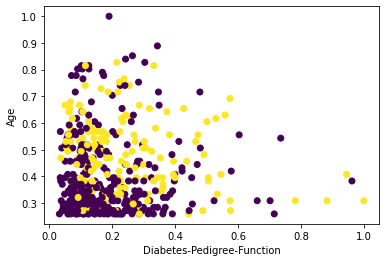

In [4]:
#There are 8 features for each of the data points. Lets plot the data using a couple of features
fig, ax = plt.subplots()
plt.scatter(train_X[6,:],train_X[7,:], c=train_Y[0])
plt.xlabel('Diabetes-Pedigree-Function')
plt.ylabel('Age')
plt.show();
# We have plotted train_X[6,:],train_X[7,:]. 
# Feel free to insert your own cells to plot and visualize different variable pairs. 

## 2. Quick Review of the Steps Involved in Logistic Regression Using Gradient Descent.

1. Training data $X$ is of dimensions $(d \times m)$ where $d$ is number of features and $m$ is number of samples. Training labels $Y$ is of dimensions $(1 \times m)$. 

2. Initilaize logistic regression model parameters $w$ and $b$ where $w$ is of dimensions $(d, 1)$ and $b$ is a scalar. $w$ is initialized to small random values and $b$ is set to zero

3. Calculate $Z$ using $X$ and intial parameter values $(w , b)$ 
<center> 
    \begin{equation*}
     Z= w^\top X + b
    \end{equation*}
</center>

4. Apply the sigmoid activation to estimate $A$ on $Z$,
<center> 
    \begin{equation*}
     A=\frac{1}{1+\text{exp}(-Z)}
    \end{equation*}
</center>

5. Calculate the loss $L()$ between predicted probabilities $A$ and groundtruth labels $Y$,
<center> 
    \begin{equation*}
     loss = logistic\_loss(A,Y)
    \end{equation*}
</center>

4. Calculate gradient dZ (or $\frac{dL}{dZ}$),
<center> 
    \begin{equation*}
     dZ = (A - Y)
    \end{equation*}
</center>

5. Calculate gradients $\frac{dL}{dw}$ represented by $dw$, $\frac{dL}{db}$ represented by $db$
<center> 
    \begin{equation*}
     dw,db = grad\_fn(X ,dZ)
    \end{equation*}
</center>
6. Adjust the model parameters using the gradients. Here $\alpha$ is the learning rate.
<center> 
    \begin{equation*}
     w := w - \alpha.dw\\
     b := b - \alpha.db
    \end{equation*}
</center>
7. Loop until the loss converges or for a fixed number of epochs. 
We will first define the functions **logistic_loss()** and **grad_fn()** along with other functions below. 

### STEP2. Defining the network's functions

We need the following functions for training and prediction:
- **Parameter initialization function** 
- **Sigmoid function**
- **Logistic loss function**
- **Gradient function**

#### Defining the parameter initialization function

The parameters here are the weights and the bias for each neuron. The weights will be initialized with small random values and bias as 0. While the bias will be a scalar, the dimension of weight vector will be $(d \times 1)$, where $d$ is the number of features.


In [5]:
def initialize(d, seed=1):
    '''
    Function to initialize the parameters for the logisitic regression model
    
    Inputs:
        d: number of features for every data point
        seed: random generator seed for reproducing the results
        
    Outputs:
        w: weight vector of dimensions (d, 1)
        b: scalar bias value
    '''
    np.random.seed(seed)
    
    # NOTE: initialize w to be a (d,1) column vector instead of (d,) vector 
    w = 0.01*np.random.randn(d,1)
    b = 0    
    return w,b

#### Defining the Sigmoid Function

Let's now implement Sigmoid activation function.

<center> 
    \begin{equation*}
    \sigma \left(z\right) = \frac{1}{1+\text{exp}(-z)}
    \end{equation*}
</center>

where z is in the input variable.

In [6]:
def sigmoid(z):
    
    A = 1/(1+np.exp(-z))
    
    return A

#### Defining the Logistic Loss Function

We will define the objective function that will be used later for determining the loss between the model prediction and groundtruth labels. We will use vectors $A$ (activation output of the logistic neuron) and $Y$ (groundtruth labels) for defining the loss. 

<center> 
    \begin{equation*}
    L(A,Y) = -\frac{1}{m}\sum_{i =1}^{m}y^{(i)}\text{log} a^{(i)} + (1-y^{(i)}) \text{log}( 1 - a^{(i)})
    \end{equation*}
</center>

where $m$ is the number of input datapoints and is used for averaging the total loss.


In [7]:
def logistic_loss(A,Y):
    '''
    Function to calculate the logistic loss given the predictions and the targets.
    
    Inputs:
        A: Estimated prediction values, A is of dimension (1, m)
        Y: groundtruth labels, Y is of dimension (1, m)
        
    Outputs:
        loss: logistic loss
    '''
    m = A.shape[1]
    loss = -1.0/m*np.sum(Y*np.log(A) + (1-Y)*np.log(1-A))
    
    return loss

#### Defining the Gradient Function

Let us define the gradient function for calculating the gradients ($\frac{dL}{dw},\frac{dL}{db}$). We will use it during gradient descent.

The gradients can be calculated as,
<center> 
    \begin{equation*}
    dw = \frac{1}{m}X( A- Y)^{T}\\
    db = \frac{1}{m}\sum_{i =1}^{m} (a^{(i)} - y^{(i)})
    \end{equation*}
</center>

Instead of $(A-Y)$, we will use dZ (or $\frac{dL}{dZ}$) since,
<center> 
    \begin{equation*}
    dZ = \left( A- Y\right)
    \end{equation*}
</center>
'keepdims' parameter.

In [8]:
def grad_fn(X,dZ):
    '''
    Function to calculate the gradients of weights (dw) and biases (db) w.r.t the objective function L.
    
    Inputs:
        X: training data of dimensions (d, m)
        dZ: gradient dL/dZ where L is the logistic loss and Z = w^T*X+b is the input to the sigmoid activation function
            dZ is of dimensions (1, m)
        
    outputs:
        dw: gradient dL/dw - gradient of the weight w.r.t. the logistic loss. It is of dimensions (d,1)
        db: gradient dL/db - gradient of the bias w.r.t. the logistic loss. It is a scalar
    '''
    m = X.shape[1]
    dw = 1.0/m*np.dot(X, dZ.T)
    db = 1.0/m*np.dot(dZ, np.ones((m,1)))
    
    return dw,db

### STEP3. Training the Model

We will now implement the steps for gradient descent discussed earlier.

In [9]:
def model_fit(w,b,X,Y,alpha,n_epochs,log=False):
    '''
    Function to fit a logistic model with the parameters w,b to the training data with labels X and Y.
    
    Inputs:
        w: weight vector of dimensions (d, 1)
        b: scalar bias value
        X: training data of dimensions (d, m)
        Y: training data labels of dimensions (1, m)
        alpha: learning rate
        n_epochs: number of epochs to train the model
        
    Outputs:
        params: a dictionary to hold parameters w and b
        losses: a list train loss at every epoch
    '''
    losses=[]
    for epoch in range(n_epochs):
        
        # Implement the steps in the logistic regression using the functions defined earlier.
        # For each iteration of the for loop
            # Step 1: Calculate output Z = w.T*X + b
            # Step 2: Apply sigmoid activation: A = sigmoid(Z)
            # Step 3: Calculate loss = logistic_loss(.) between predicted values A and groundtruth labels Y
            # Step 4: Estimate gradient dZ = A-Y
            # Step 5: Estimate gradients dw and db using grad_fn(.).
            # Step 6: Update parameters w and b using gradients dw, db and learning rate
            #         w = w - alpha * dw
            #         b = b - alpha * db

        #step1
        Z = np.dot(w.T,X) + b
        
        #step2
        A = sigmoid(Z)
        
        #step3
        loss = logistic_loss(A,Y)
        
        #step4
        dZ = A - Y
        
        #step5
        dw,db = grad_fn(X,dZ)
        
        #step 6
        
        w = w - alpha*dw
        b = b - alpha*db
        
        if epoch%100 == 0:
            losses.append(loss)
            if log == True:
                print("After %i iterations, Loss = %f"%(epoch,loss))
    params ={"w":w,"b":b}
    
    return params,losses    

### STEP4. Model Prediction

Once we have the optimal values of model parameters $(w,b)$, we can determine the accuracy of the model on the test data.
<center> 
    \begin{equation*}
     Z = w^{T}X + b\\
     A=\sigma\left(Z\right)  
    \end{equation*}
</center>

In [10]:
def model_predict(params,X,Y=np. array([]),pred_threshold=0.5):
    '''
    Function to calculate category predictions on given data and returns the accuracy of the predictions.
    Inputs:
        params: a dictionary to hold parameters w and b
        X: training data of dimensions (d, m)
        Y: training data labels of dimensions (1, m). If not provided, the function merely makes predictions on X
        
    outputs:
        Y_Pred: Predicted class labels for X. Has dimensions (1, m)
        acc: accuracy of prediction over X if Y is provided else, 0 
        loss: loss of prediction over X if Y is provided else, Inf  
    '''
    w = params['w']
    b = params['b']
    m = X.shape[1]
    
    # Calculate Z using X, w and b
    Z = np.dot(w.T,X) + b
    # Calculate A using the sigmoid - A is the set of (1,m) probabilities
    A = sigmoid(Z)
    # Calculate the prediction labels Y_Pred of size (1,m) using A and pred_threshold 
    Y_Pred = np.zeros((1,m))
    
    # When A>pred_threshold Y_Pred is 1 else 0

    for i in (range(0,m)):
        if(A[0][i] > pred_threshold):
            Y_Pred[0][i] = 1
    
    acc = 0
    loss = float('inf')
    if Y.size!=0:
        loss = logistic_loss(A,Y)
        acc = np.mean(Y_Pred==Y)
    return Y_Pred, acc, loss

### STEP5. Evaluating the model

We will train our logistic regression model using the data we have loaded and test our predictions on diabetes classification.

In [11]:
alpha = 0.5
n_epochs = 4000

# Write code to initialize parameters w and b with initialize(.) (use train_X to get feature dimensions d)
w,b = initialize(train_X.shape[0])
# Use model_fit(.) to estimate the updated 'params' of the logistic regression model and calculate how the 'losses' varies 
# Use variables 'params' and 'losses' to store the outputs of model_fit(.) 
params, losses = model_fit(w,b,test_X,test_Y,alpha,n_epochs)

Train Accuracy of the model: 0.746
Test Accuracy of the model: 0.7947761194029851


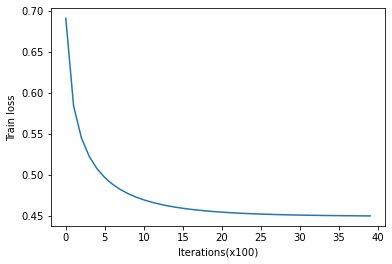

In [12]:
Y_Pred_tr, acc_tr, loss_tr = model_predict(params,train_X,train_Y)
Y_Pred_ts, acc_ts, loss_ts = model_predict(params,test_X,test_Y)
print("Train Accuracy of the model:",acc_tr)
print("Test Accuracy of the model:",acc_ts)
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(losses)
plt.xlabel('Iterations(x100)')
plt.ylabel('Train loss');